# 👽👾 `print(fiction)` 📚🛸

> #### A data science project by _Tobias Reaper_

#### 📓 Notebook 3: Modeling 🧠

---

### Notebook Outline

[explanation of this notebook in context of project]

* [Introduction](#Introduction)
  * Imports and configuration
* [Load Data](#Load-Data)
* [Baseline Models](#Baseline-Models)
  * Majority class baseline
  * Limited logistic baseline
  * Default random forest
* [Model Validation](#Model-Validation)
  * Feature engineering
  * Feature pruning with permutation importances
  * Iteration
    * Cross-validation
    * Hyperparameter tuning
    * Algorithms
      * Logistic regression
      * Nearest neighbors
      * Gradient boosting
      * Random forest
* [Results and interpretation](#Results-and-Interpretation)

---

## Introduction

`print(fiction)` is a solo project I worked on to explore the data on and around stories—specifically, the stories contained in print books.

I used Scrapy to scrape metadata for over 20,000 books from GoodReads and used it to train a gradient-boosted random forest classifier. The final version of the model classified books as either fiction or nonfiction with 88% accuracy.

The dataset is freely available for download from GitHub or Kaggle (link to come).
I built an interactive dashboard using Plotly Dash that can be used to tinker with the model parameters and view the resulting prediction in real time.

You can find the current live version of the app here: [print(fiction)](http://print-fiction.herokuapp.com/)

The notebooks detailing the entire process of data gathering, wrangling, modeling, and deployment, can be found here: [print(fiction) notebooks](https://github.com/tobias-fyi/print-fiction/tree/master/notebooks)

---

### Imports and Configuration

⚙️📥

In [1]:
# === General Imports === #
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import randint, uniform

In [2]:
# === Configure === #
%matplotlib inline
pd.options.display.max_rows = 200
pd.options.display.max_columns = 200

In [3]:
# %%capture
# !pip install category-encoders
# !pip install eli5

In [62]:
# === ML Imports === #

# Preprocessing
import category_encoders as ce
from sklearn.preprocessing import StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer

# Model validation
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    f1_score,
    classification_report,
    roc_auc_score,
)

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# Interpretations
import eli5
from eli5.sklearn import PermutationImportance

---

## Load Data

In [5]:
# === Load the dataset === #
# This version was exported from the previous notebook
# after doing some initial wrangling
data_path = "https://raw.githubusercontent.com/tobias-fyi/vela/master/ds/interview_prep/practice/print-fiction/assets/must_read_books-02.csv"

books = pd.read_csv(data_path, na_values="?")
print(books.shape)
books.head(3)

(18344, 18)


,title,author,num_ratings,num_reviews,avg_rating,num_pages,language,series,1_rating_count,2_rating_count,3_rating_count,4_rating_count,5_rating_count,publish_year,publish_month,publish_day,fiction,republish
0,The Book of Mormon: Another Testament of Jesus...,Anonymous,71355.0,5704.0,4.37,531.0,English,0,7520.0,2697.0,2521.0,1963.0,56654.0,2013.0,10.0,22.0,0,1
1,The Prince,Niccolò Machiavelli,229715.0,7261.0,3.81,140.0,English,0,5254.0,16827.0,61182.0,80221.0,66231.0,2003.0,6.0,1.0,0,1
2,The Foundation Trilogy,Isaac Asimov,83933.0,1331.0,4.40,679.0,English,1,477.0,1521.0,9016.0,25447.0,47472.0,1974.0,1.0,1.0,1,1


In [6]:
# === Confirm null values were read in correctly === #
books.isnull().sum()

title                0
author               0
num_ratings          0
num_reviews          0
avg_rating           0
num_pages          666
language          1332
series               0
1_rating_count      83
2_rating_count      83
3_rating_count      83
4_rating_count      83
5_rating_count      83
publish_year       282
publish_month      282
publish_day        282
fiction              0
republish            0
dtype: int64

---

## Baseline Models

* Split data into train, validation, and test sets
* Choose an appropriate evaluation metric
* Get baseline model eval scores

In [7]:
# === Split data into train / val / test === #
train, test = train_test_split(books, stratify=books["fiction"], test_size=0.2, random_state=92)
train, val = train_test_split(train, stratify=train["fiction"], test_size=0.2, random_state=92)

train.shape, val.shape, test.shape

((11740, 18), (2935, 18), (3669, 18))

In [8]:
# === Set up target and features === #
target = "fiction"

# Arrange y vector
y_train = train[target]
y_val = val[target]
y_test = test[target]

print(y_train.shape, y_val.shape, y_test.shape)

# Arrange X matrices
X_train = train.drop(columns=[target])
X_val = val.drop(columns=[target])
X_test = test.drop(columns=[target])

print(X_train.shape, X_val.shape, X_test.shape)

(11740,) (2935,) (3669,)
(11740, 17) (2935, 17) (3669, 17)


1    6145
0    5595
Name: fiction, dtype: int64


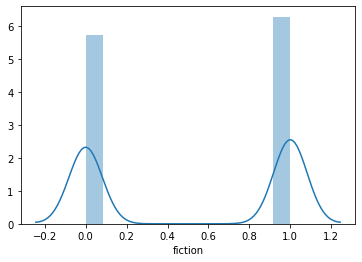

In [9]:
# === Target distribution === #
print(y_train.value_counts())
sns.distplot(y_train);

#### Majority class baseline

In [52]:
# === Use mode as predictions === #
maj = y_train.mode()[0]  # Mode is 1 (fiction)

# Simply predict 1 for every training example
y_pred_maj = [maj] * len(y_train)

# Baseline accuracy
print(accuracy_score(y_train, y_pred_maj))
print(f1_score(y_train, y_pred_maj))

0.5234071550255537
0.687153336911791


#### Limited logistic baseline

In [11]:
# === Use only a few features for this baseline === #
base_features = [
    "num_reviews",
    "avg_rating",
    "num_pages",
]

# Arrange X matrices
X1_train = train[base_features]
X1_val = val[base_features]
X1_test = test[base_features]

X1_train.shape, X1_val.shape, X1_test.shape

((11740, 3), (2935, 3), (3669, 3))

In [12]:
# === Limited logistic baseline model === #
pipe1 = Pipeline([
    ("scaler", StandardScaler()),
    ("imputer", SimpleImputer(strategy="median")),
    ("logreg", LogisticRegression(random_state=92)),
])

# Train base logistic pipeline
pipe1.fit(X1_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('imputer', SimpleImputer(strategy='median')),
                ('logreg', LogisticRegression(random_state=92))])

In [50]:
# === Made predictions to get validation accuracy === #
y_pred1 = pipe1.predict(X1_val)

# Compute accuracy
print("Baseline accuracy:", accuracy_score(y_val, y_pred1))
print("Baseline F1:", f1_score(y_val, y_pred1))

Baseline accuracy: 0.6275979557069846
Baseline F1: 0.6513556618819776


In [14]:
# === Baseline confusion matrix === #
confusion_matrix(y_val, y_pred1)

array([[ 821,  578],
       [ 515, 1021]])

#### Default Random Forest

In [15]:
# === Default random forest model === #
def_drop_columns = [
    "title",
    "author",
    "language",
]

X2_train = X_train.drop(columns=def_drop_columns)
X2_val = X_val.drop(columns=def_drop_columns)
X2_test = X_test.drop(columns=def_drop_columns)

rf1_pipe = Pipeline([
    ("encoder", ce.OrdinalEncoder()),
    ("imputer", SimpleImputer(strategy="median")),
    ("rfc", RandomForestClassifier(random_state=92)),
])

# Train default random forest
rf1_pipe.fit(X2_train, y_train)

# Made predictions to get validation accuracy
y_pred_rf1 = rf1_pipe.predict(X2_val)

# Compute evaluation metrics
print("Default random forest eval metrics:")
print("  Accuracy:", accuracy_score(y_val, y_pred_rf1))
print("  F1 score:", f1_score(y_val, y_pred_rf1))

Default random forest eval metrics:
  Accuracy: 0.7342419080068143
  F1 score: 0.7477360931435963


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


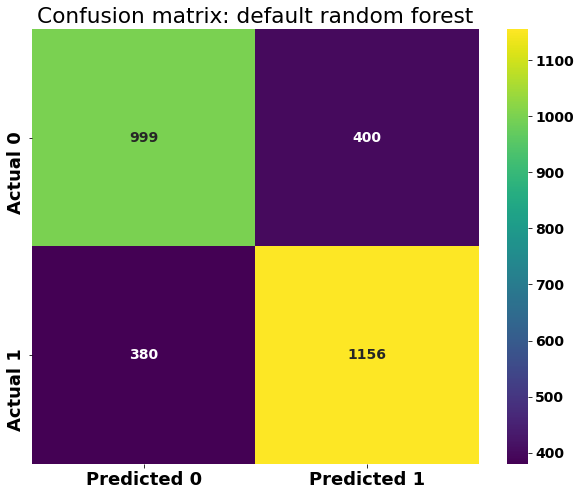

In [61]:
# === Evaluate default rf with confusion matrix === #
from sklearn.utils.multiclass import unique_labels

unique_labels(y_val)  # Create unique labels

def plot_confusion_matrix(y_true, y_pred):
    labels = unique_labels(y_true)
    columns = [f'Predicted {label}' for label in labels]
    index = [f'Actual {label}' for label in labels]
    table = pd.DataFrame(confusion_matrix(y_true, y_pred), 
                         columns=columns, index=index)
    return sns.heatmap(table, annot=True, fmt='d', cmap='viridis')

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
plt.title("Confusion matrix: default random forest")
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 14}
plt.rc('font', **font)
plot_confusion_matrix(y_val, y_pred_rf1);

In [19]:
# === Classification report === #
from sklearn.metrics import classification_report

print(classification_report(y_val, y_pred_rf1))

              precision    recall  f1-score   support

           0       0.72      0.71      0.72      1399
           1       0.74      0.75      0.75      1536

    accuracy                           0.73      2935
   macro avg       0.73      0.73      0.73      2935
weighted avg       0.73      0.73      0.73      2935



---

## Model Validation

Iterate and Validate Models

* [x] Engineer new features
* [x] Feature pruning with permutation importance
* [x] Use cross-validation (RandomizedSearchCV) to tune hyperparameters
* [x] Try out different algorithms
  * [x] KNearestClassifier
  * [x] XGBClassifier

### Evaluation metrics

Alrighty then! With the (almost) full set of features and default hyperparameters the target can be predicted with ~73% accuracy. Although the target is not skewed very much, it is still skewed. Therefore, accuracy may not be the best way to evaluate the model. A better metric could be the F1 score. This is a little higher than the accuracy, clocking in at almost 75%.

The F1 score is made up of the precision and recall. Actually, it can be interpreted of as the weighted average of precision and recall.

This provides a better method of evaluating performance, because it takes into account false positives and false negatives. Accuracy only accounts for the model's correct predictions and mistakes, irrespective of _how_ the model made those mistakes.

Let's see what we can do to increase that score.

### Feature Engineering

When I initially started this project, I went through the process of validating and training a model or two that tried to predict the average rating of books. This was by far the most common target chosen by those who started Kaggle kernels using other GoodReads datasets. Although this may have the most obvious business value if I was a data scientist working for a book publisher, to me this wasn't a particularly interesting target to try to predict.

I realized this when I hit a wall with my progress in improving the rating-predictor model. One reason was that I did not see any obvious useful features that could be engineered. However, once I found my way to the idea of predicting the fictionality of the books, the target drove the direction I took with my feature engineering. It was a great learning experience for me in engineering features toward the specific target that the model is trying to predict.

Here are the feature ideas I came up with and engineered (all in short succession once the new target was chosen):

- [x] Title begins with "The"
- [x] Has subtitle: contains ":"
- [x] Title character count
- [x] Title word count
- [x] Title longest word
- [x] Author number of names
- [x] Author middle initial
- [x] Ratings (stars) ratio (1 + 2 / 4 + 5)

In [20]:
def engineer_features(data):
    """Engineer a handful of new features."""
    # Create new feature that is if the title begins with "The"
    data["the_title"] = data["title"].str.startswith("The")
    # New feature - has_subtitle
    data["has_subtitle"] = data["title"].str.contains(":")
    # New feature - title character length
    data["title_char_count"] = data["title"].apply(lambda x: len(x))
    # New feature - title word count
    data["title_word_count"] = data["title"].apply(lambda x: len(x.split()))
    # New feature - title longest word
    data["title_longest_word"] = data["title"].apply(lambda x: len(max(x.split(), key=len)))
    # New feature - author number of names
    data["author_name_count"] = data["author"].apply(lambda x: len(x.split()))
    # New feature - author middle initial
    pat = r"\w* (\w. )+ \w*"
    data["author_middle_initial"] = data["author"].str.contains(pat, regex=True)
    # New feature - low/high rating ratio
    data["rating_ratio"] = (data["1_rating_count"] + data["2_rating_count"]) / (data["4_rating_count"] + data["5_rating_count"])
    # Replace Boolean with binary
    data = data.replace(to_replace={True: 1, False:0})
    return data

#### Same random forest with additional features

In [21]:
# === Random forest model, new features === #
X3_train = engineer_features(X_train)
X3_val = engineer_features(X_val)
X3_test = engineer_features(X_test)

rf2_pipe = Pipeline([
    ("encoder", ce.OrdinalEncoder()),
    ("imputer", SimpleImputer(strategy="median")),
    ("rfc", RandomForestClassifier(random_state=92)),
])

# Train default random forest
rf2_pipe.fit(X3_train, y_train)

# Made predictions to get validation accuracy
y_pred_rf2 = rf2_pipe.predict(X3_val)

# Compute evaluation metrics
print("Default random forest eval metrics:")
print("  Accuracy:", accuracy_score(y_val, y_pred_rf2))
print("  F1 score:", f1_score(y_val, y_pred_rf2))

/Users/Tobias/.vega/vela-_qIiF1eP/lib/python3.7/site-packages/pandas/core/strings.py:1954: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


Default random forest eval metrics:
  Accuracy: 0.7761499148211244
  F1 score: 0.7884057971014492


Got an extra ~3-4% out of those new features!

And that is with the default RandomForestClassifier hyperparameters and the SimpleImputer. For the next iteration, I will try using the IterativeImputer, then utilize RandomizedSearchCV to tune the hyperparameters and conduct cross-validation.

### Permutation Importances

It is likely that some of the features do not help the model make correct predictions. Indeed, some may even be worse than that: they could add noise that makes the model perform worse.

To address this potential problem, I'm going to find the feature importances using a method called permutation importance. Basically, this method will go through each of the features, replacing their data with random noise generated from the distribution of the original data. The performance of the model will be evaluated and compared with the score using all of the original data to find the effect of each feature on the performance of the model.

In [22]:
# === Transformer pipeline === #
# Use the same (fitted) steps from main pipeline
transformers = Pipeline([
    ("encoder", rf2_pipe.named_steps["encoder"]),
    ("imputer", rf2_pipe.named_steps["imputer"]),
])

# Encode and impute
X3_train_transformed = transformers.transform(X3_train)
X3_val_transformed = transformers.transform(X3_val)

In [23]:
# === Instantiate and fit the permuter === #
permuter = PermutationImportance(
    rf2_pipe.named_steps["rfc"], 
    scoring='f1', 
    n_iter=5, 
    random_state=42
)

permuter.fit(X3_val_transformed, y_val)

PermutationImportance(estimator=RandomForestClassifier(random_state=92),
                      random_state=42, scoring='f1')

In [24]:
# === Get permutation importances === #
feature_names = X3_val.columns.tolist()
pd.Series(permuter.feature_importances_, feature_names).sort_values(ascending=False)

eli5.show_weights(
    permuter, 
    top=None, # Show permutation importances for all features
    feature_names=feature_names
)

Weight,Feature
0.0307 ± 0.0021,has_subtitle
0.0264 ± 0.0116,avg_rating
0.0197 ± 0.0066,4_rating_count
0.0193 ± 0.0031,publish_year
0.0153 ± 0.0059,num_ratings
0.0124 ± 0.0039,series
0.0116 ± 0.0071,1_rating_count
0.0096 ± 0.0048,num_pages
0.0078 ± 0.0099,num_reviews
0.0073 ± 0.0091,3_rating_count


Based on the above table, I should see either no change or a small increase in the model's performance by removing `publish_month`, `author`, `title_word_count`, `title`, and `publish_day`. I'm going to try removing those and training the model again.

As for the rest of the features, I find it interesting to see what features have the largest positive effect on the model's predictive power. From this table, I can see that the majority of the benefit I got from engineering the new features came from `has_subtitle`. This feature, according to the permutation importance table, is the most important predictor of the lot, and simply indicates whether the title of the book has a colon in it. My intuition was that having a subtitle is very common for nonfiction books, not so much for fiction. It seems that my intuition was generally good.

In [25]:
# === Prune the features === #
more_drop_cols = [
    "publish_month",
    "author",
    "title_word_count",
    "title",
    "publish_day",
]

# New features are already engineered
X4_train = X3_train.drop(columns=more_drop_cols)
X4_val   = X3_val.drop(columns=more_drop_cols)
X4_test  = X3_test.drop(columns=more_drop_cols)

In [26]:
# === Random forest model with pruned features === #
rf3_pipe = Pipeline([
    ("encoder", ce.OrdinalEncoder()),
    ("imputer", SimpleImputer(strategy="median")),
    ("rfc", RandomForestClassifier(random_state=92)),
])

# Train default random forest
rf3_pipe.fit(X4_train, y_train)

# Made predictions to get validation accuracy
y_pred_rf3 = rf3_pipe.predict(X4_val)

# Compute evaluation metrics
print("Default random forest:")
print("  Accuracy:", accuracy_score(y_val, y_pred_rf3))
print("  F1 score:", f1_score(y_val, y_pred_rf3))

Default random forest:
  Accuracy: 0.7867120954003407
  F1 score: 0.7991014120667522


It seems that removing the features indicated did have a positive effect of about 0.01 on the model's performance.

In [27]:
# === Logistic regression, pruned features === #
lg_pipe = Pipeline([
    ("encoder", ce.OrdinalEncoder()),
    ("scaler", StandardScaler()),
    ("imputer", SimpleImputer(strategy="median")),
    ("lg", LogisticRegression(random_state=92)),
])

# Train default logistic model
lg_pipe.fit(X4_train, y_train)

# Made predictions to get validation accuracy
y_pred_lg = lg_pipe.predict(X4_val)

# Compute evaluation metrics
print("Default logistic model:")
print("  Accuracy:", accuracy_score(y_val, y_pred_lg))
print("  F1 score:", f1_score(y_val, y_pred_lg))

Default logistic model:
  Accuracy: 0.7315161839863714
  F1 score: 0.7612121212121213


Based on the performance of the logistic model, it does seem that random forest is a better model for the problem at hand.

### Iteration

As I mentioned above, a good approach to finding and training the best model for a particular problem and dataset is to start simple and iterate. I already iterated to select the best features. Next up was to iterate on algorithms and their various hyperparameters.

#### Cross-validation

Up until this point, I had been using a consistent train-test-validation set split. However, now that I was going to be tuning hyperparameters, it made sense to start using cross-validation. I won't get into the details of what that is in this particular article. If you're curious, search for it on Duck Duck Go, or read about it in [The Python Data Science Handbook](https://jakevdp.github.io/PythonDataScienceHandbook/05.03-hyperparameters-and-model-validation.html#Model-validation-via-cross-validation).

#### Hyperparameter tuning

Hyperparameters are the parameters of the model that are not directly learned during the training process—they must be adjusted manually. My preferred method of tuning them is with a randomized search.

Essentially, I provide a list of hyperparameters to tune and a search window or distribution for each one. The algorithm runs through a specified number of iterations, each time randomly selecting values for each hyperparameter from their respective distribution and using them to train a new model. Each model is evaluated after each iteration using cross-validation. Then, once the search is over, the pipeline is refitted using the values that resulted in the model with the best cross-validation score.

As the search is random and limited to a reasonable number of iterations, some strategy is involved to find optimal search windows/distributions for each hyperparameter. The method I used for this is to start out searching a wide range of values, and go through the process a few times, progressively narrowing the range around the values that come up as consistently optimal.

In [28]:
# === Engineer the new features === #
# Start from original dataset -> train / test
books2 = engineer_features(books)

/Users/Tobias/.vega/vela-_qIiF1eP/lib/python3.7/site-packages/pandas/core/strings.py:1954: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


In [29]:
# === Split data into train / test === #
train, test = train_test_split(books2, stratify=books2["fiction"], test_size=0.2, random_state=92)

train.shape, test.shape

((14675, 26), (3669, 26))

In [30]:
# === Take a look === #
print(train.shape)
train.head(2)

(14675, 26)


,title,author,num_ratings,num_reviews,avg_rating,num_pages,language,series,1_rating_count,2_rating_count,3_rating_count,4_rating_count,5_rating_count,publish_year,publish_month,publish_day,fiction,republish,the_title,has_subtitle,title_char_count,title_word_count,title_longest_word,author_name_count,author_middle_initial,rating_ratio
2298,El árbol de la ciencia,Pío Baroja,4746.0,183.0,3.72,255.0,Spanish,1,155.0,439.0,1189.0,1766.0,1197.0,2005.0,1.0,1.0,0,1,0,0,22,5,7,2,0,0.200472
9533,The Day the World Came to Town: 9/11 in Gander...,Jim DeFede,16319.0,2749.0,4.17,256.0,English,0,61.0,356.0,2718.0,6718.0,6466.0,2003.0,8.0,14.0,0,1,1,1,60,11,12,2,0,0.031629


In [31]:
# === Set up target and features === #
# No val this time bc using cross-validation
target = "fiction"

drop_cols = [  # Columns not useful to model
    "title",
    "author",
    "language",
    "publish_month",
    "publish_day",
    "author_middle_initial",
    "title_word_count",
]

# Arrange y vector
y_train = train[target]
y_test = test[target]

print(y_train.shape, y_test.shape)

# Arrange X matrices
X_train = train.drop(columns=[target] + drop_cols)
X_test = test.drop(columns=[target] + drop_cols)

print(X_train.shape, X_test.shape)

(14675,) (3669,)
(14675, 18) (3669, 18)


#### Validation

Before getting too deep into tuning the hyperparameters of a specific algorithm (it is computationally expensive to run exhaustive searches), I thought it best to test out a few different algorithms. I started out with the assumption that random forest or gradient-boosting would provide the best results, but it's generally good to test assumptions.

Though I did not test a very wide range of algorithms, I figured it would be worth it anyways to see if any of the more commonly-used ones showed any promise.

Somewhat to my surprise, the best models from tuning and cross-validation were basically on par with the default, non-cross-validated random forest.

The fact that the baseline was trained without using cross-validation could be one reason. In other words, the best model from the search might generalize better to new data; it could outperform the default one on the test dataset.

Or, it could be a result of the parameters and their ranges I searched—i.e. not giving a wide enough initial distribution. However, the wider the distribution, if the number of iterations is relatively low, the more "noise" might be present in the results of the search. I wanted to wait until I chose an algorithm to try increasing the number of search iterations significantly.

Here is the full list of algorithms I trained during the validation and iteration process, and their best F1 score:

* Logistic regression: ~.76
* K-nearest neighbors: ~.69
* Random forest: ~.80
* Gradient-boosted decision tree: ~.80

#### Final algorithm

Even with 40 total fits (4 cross-validation folds, 10 iterations) the gradient-boosted classifier did not really outperform the random forest by any significant margin. Given the additional complexity and computation required for an XGBoost (gradient-boosting) model, I decided to move forward with the random forest classifier.

To continue testing the hypothesis that my initial number of iterations was too low for the search to converge on a good combination of hyperparameters, I trained more random forests with higher numbers of search iterations.

To my continued surprise, even after many, many more iterations, the absolute best F1 score I got still hovered right around ~.80.

In [32]:
# === Random forest, Part 4 === #
rf4_pipe = Pipeline([
    ("encoder", ce.OrdinalEncoder()),
    ("imputer", IterativeImputer(random_state=92, n_nearest_features=3, imputation_order="random")),
    ("rfc", RandomForestClassifier(random_state=92)),
])

rf4_params = {
    "imputer__initial_strategy": ["median", "most_frequent"],
    "imputer__max_iter": randint(4, 28),
    "imputer__tol": uniform(0.01, 0.1),
    "rfc__n_estimators": randint(140, 300),
    "rfc__max_depth": randint(12, 32),
    "rfc__min_samples_split": randint(8, 28),
    "rfc__min_impurity_decrease": uniform(0, .01),
}

# Define the search using parameter distros above
rf4_search = RandomizedSearchCV(
    rf4_pipe,
    param_distributions=rf4_params,
    n_iter=30,
    cv=5,
    scoring='f1',
    verbose=10,
    return_train_score=True,
    n_jobs=-1,
    random_state=92,
)

# Train default random forest
rf4_search.fit(X_train, y_train)

# Best combination of hyperparameters and their resulting f1 score
print('F1 score', rf4_search.best_score_)
print('\nBest hyperparameters:')
for param, val in rf4_search.best_params_.items():
    print(f"  {param}: {val}")

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   21.2s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   27.3s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   31.8s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   40.1s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   48.0s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   56.6s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  2.1min finished


F1 score 0.7925802698030067

Best hyperparameters:
  imputer__initial_strategy: median
  imputer__max_iter: 5
  imputer__tol: 0.013193153149812033
  rfc__max_depth: 17
  rfc__min_impurity_decrease: 0.00011414922662247307
  rfc__min_samples_split: 17
  rfc__n_estimators: 229


---

## Results and Interpretation

At this point, I did not want to waste any more time or compute power trying to find that last little bit of optimization. So, it was time to evaluate the final model, interpret its predictions, then deploy it.

### Evaluating the final model

Finally it was time to unlock the test data and see how the model does. The result was an F1 score slightly north of .78.

Here is the confusion matrix derived from the model's predictions on the test set:

In [33]:
# === How does it perform on the test data? === #
y_pred_test_rf4 = rf4_search.predict(X_test)

# Compute evaluation metrics
print("Random forest 4 eval metrics:")
print("  Accuracy:", accuracy_score(y_test, y_pred_test_rf4))
print("  F1 score:", f1_score(y_test, y_pred_test_rf4))

Random forest 4 eval metrics:
  Accuracy: 0.7672390297083674
  F1 score: 0.7833587011669203


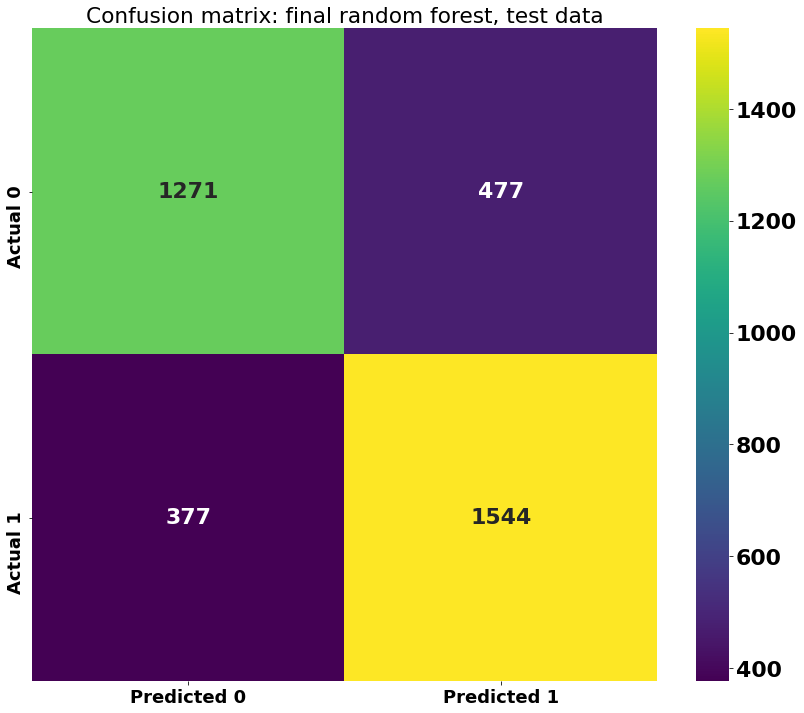

In [72]:
# === Plot final confusion matrix === #
plt.figure(figsize=(14, 12))
plt.title("Confusion matrix: final random forest, test data")
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}
plt.rc('font', **font)
plot_confusion_matrix(y_test, y_pred_test_rf4);

In [35]:
# Get indexes as an id field to match up on later
train_id = X_train.reset_index()["index"]
test_id = X_test.reset_index()["index"]

In [36]:
test_id.head()

0     1042
1    10779
2    10072
3    15540
4    13007
Name: index, dtype: int64

In [37]:
# === ROC AUC + predicted probabilities === #

# Process the test data
transformers_2 = Pipeline([
    ("encoder", rf4_search.best_estimator_["encoder"]),
    ("imputer", rf4_search.best_estimator_["imputer"]),
])

# Encode and impute
X_test_transform = transformers_2.transform(X_test)
class_index = 1

# Make predictions with the trained random forest
y_pred_proba_rf4 = rf4_search.predict_proba(X_test_transform)[:, class_index]

# ROC AUC score ranges from 0-1; higher is better
print(f'Test ROC AUC for class {class_index}:')
print(roc_auc_score(y_test, y_pred_proba_rf4))

Test ROC AUC for class 1:
0.8489270700686261


In [38]:
# === Reset index of test set to get column to match on === #
X_test = X_test.reset_index()
X_test.head()

,index,num_ratings,num_reviews,avg_rating,num_pages,series,1_rating_count,2_rating_count,3_rating_count,4_rating_count,5_rating_count,publish_year,republish,the_title,has_subtitle,title_char_count,title_longest_word,author_name_count,rating_ratio
0,1042,112871.0,4674.0,4.00,317.0,0,1593.0,5439.0,24255.0,41993.0,39591.0,1997.0,1,0,0,29,7,2,0.086193
1,10779,364.0,47.0,3.97,431.0,0,12.0,16.0,72.0,134.0,130.0,2016.0,1,0,0,18,8,2,0.106061
2,10072,49.0,12.0,4.18,294.0,0,0.0,3.0,10.0,11.0,25.0,1994.0,0,0,0,16,8,2,0.083333
3,15540,150.0,14.0,3.87,200.0,1,0.0,2.0,46.0,71.0,31.0,1994.0,0,0,0,16,6,2,0.019608
4,13007,19322.0,213.0,4.09,268.0,1,285.0,986.0,3758.0,5984.0,8309.0,1993.0,1,0,1,40,11,2,0.088925


In [39]:
# === Confirm all the shapes match up === #
X_test.shape, test_id.shape, y_pred_test_rf4.shape, y_pred_proba_rf4.shape, y_test.shape

((3669, 19), (3669,), (3669,), (3669,), (3669,))

In [40]:
y_test.reset_index().head()

,index,fiction
0,1042,1
1,10779,0
2,10072,0
3,15540,1
4,13007,1


In [41]:
# === Compare true / pred === #
# Create new dataframe to compare the predictions to the actual
df = pd.DataFrame({
    "index": test_id,
    "pred": y_pred_test_rf4,
    "pred_proba": y_pred_proba_rf4,
})

print(df.shape)
df.head()

(3669, 3)


,index,pred,pred_proba
0,1042,1,0.926309
1,10779,1,0.550764
2,10072,0,0.159053
3,15540,1,0.561363
4,13007,1,0.529370


In [42]:
# === Merge in actuals === #
df = df.merge(y_test.reset_index())

print(df.shape)
df.head()

(3669, 4)


,index,pred,pred_proba,fiction
0,1042,1,0.926309,1
1,10779,1,0.550764,0
2,10072,0,0.159053,0
3,15540,1,0.561363,1
4,13007,1,0.529370,1


In [43]:
# === Merge the rest of the features back in === #
df = df.merge(
     X_test,
     how='left'
)

print(df.shape)
df.head()

(3669, 22)


,index,pred,pred_proba,fiction,num_ratings,num_reviews,avg_rating,num_pages,series,1_rating_count,2_rating_count,3_rating_count,4_rating_count,5_rating_count,publish_year,republish,the_title,has_subtitle,title_char_count,title_longest_word,author_name_count,rating_ratio
0,1042,1,0.926309,1,112871.0,4674.0,4.00,317.0,0,1593.0,5439.0,24255.0,41993.0,39591.0,1997.0,1,0,0,29,7,2,0.086193
1,10779,1,0.550764,0,364.0,47.0,3.97,431.0,0,12.0,16.0,72.0,134.0,130.0,2016.0,1,0,0,18,8,2,0.106061
2,10072,0,0.159053,0,49.0,12.0,4.18,294.0,0,0.0,3.0,10.0,11.0,25.0,1994.0,0,0,0,16,8,2,0.083333
3,15540,1,0.561363,1,150.0,14.0,3.87,200.0,1,0.0,2.0,46.0,71.0,31.0,1994.0,0,0,0,16,6,2,0.019608
4,13007,1,0.529370,1,19322.0,213.0,4.09,268.0,1,285.0,986.0,3758.0,5984.0,8309.0,1993.0,1,0,1,40,11,2,0.088925


In [45]:
# === Filter for incorrect predictions === #
df_wrong = df[df["pred"] != df["fiction"]]
print(df_wrong.shape)
df_wrong.head()

(854, 22)


,index,pred,pred_proba,fiction,num_ratings,num_reviews,avg_rating,num_pages,series,1_rating_count,2_rating_count,3_rating_count,4_rating_count,5_rating_count,publish_year,republish,the_title,has_subtitle,title_char_count,title_longest_word,author_name_count,rating_ratio
1,10779,1,0.550764,0,364.0,47.0,3.97,431.0,0,12.0,16.0,72.0,134.0,130.0,2016.0,1,0,0,18,8,2,0.106061
7,5437,1,0.617281,0,2650.0,92.0,3.96,304.0,0,49.0,154.0,590.0,927.0,930.0,1987.0,1,1,0,45,9,2,0.109316
9,9875,1,0.601987,0,3073.0,82.0,4.25,659.0,0,22.0,65.0,469.0,1091.0,1426.0,1976.0,1,1,0,17,8,2,0.034565
10,2513,0,0.306036,1,1471.0,345.0,3.80,308.0,1,96.0,142.0,298.0,358.0,577.0,2011.0,0,0,0,8,8,2,0.254545
13,3274,0,0.130823,1,60322.0,2623.0,4.04,365.0,0,377.0,2063.0,12538.0,25237.0,20107.0,2005.0,1,0,1,46,9,2,0.053811


In [47]:
# === Get titles, because I'm curious === #
df_wrong = df_wrong.merge(books.iloc[df_wrong["index"]]["title"].reset_index())
print(df_wrong.shape)
df_wrong.head()

(854, 23)


,index,pred,pred_proba,fiction,num_ratings,num_reviews,avg_rating,num_pages,series,1_rating_count,2_rating_count,3_rating_count,4_rating_count,5_rating_count,publish_year,republish,the_title,has_subtitle,title_char_count,title_longest_word,author_name_count,rating_ratio,title
0,10779,1,0.550764,0,364.0,47.0,3.97,431.0,0,12.0,16.0,72.0,134.0,130.0,2016.0,1,0,0,18,8,2,0.106061,Whispers of Heaven
1,5437,1,0.617281,0,2650.0,92.0,3.96,304.0,0,49.0,154.0,590.0,927.0,930.0,1987.0,1,1,0,45,9,2,0.109316,The Condition of the Working Class in England
2,9875,1,0.601987,0,3073.0,82.0,4.25,659.0,0,22.0,65.0,469.0,1091.0,1426.0,1976.0,1,1,0,17,8,2,0.034565,The Portable Jung
3,2513,0,0.306036,1,1471.0,345.0,3.80,308.0,1,96.0,142.0,298.0,358.0,577.0,2011.0,0,0,0,8,8,2,0.254545,Creatura
4,3274,0,0.130823,1,60322.0,2623.0,4.04,365.0,0,377.0,2063.0,12538.0,25237.0,20107.0,2005.0,1,0,1,46,9,2,0.053811,Smoke and Mirrors: Short Fiction and Illusions


In [73]:
df_wrong.sample(n=60, random_state=92).sort_values(by="pred_proba")

,index,pred,pred_proba,fiction,num_ratings,num_reviews,avg_rating,num_pages,series,1_rating_count,2_rating_count,3_rating_count,4_rating_count,5_rating_count,publish_year,republish,the_title,has_subtitle,title_char_count,title_longest_word,author_name_count,rating_ratio,title
113,6021,0,0.081860,1,42.0,19.0,3.83,NaN,0,2.0,1.0,9.0,20.0,10.0,2013.0,1,0,1,62,8,2,0.100000,"Raised by Hand, Lifted by the Tides: A Souther..."
671,10557,0,0.151352,1,146.0,19.0,3.84,96.0,0,4.0,6.0,42.0,52.0,42.0,1999.0,1,0,1,38,10,2,0.106383,Sanctuary: A Tale of Life in the Woods
589,7885,0,0.201978,1,24.0,8.0,3.75,270.0,0,3.0,0.0,6.0,6.0,9.0,2011.0,0,0,0,41,17,2,0.200000,"Our Father, Who Art Out There...Somewhere"
601,17626,0,0.294917,1,334.0,41.0,4.17,228.0,0,6.0,7.0,55.0,121.0,145.0,1996.0,1,0,0,32,9,2,0.048872,"Farewell, I'm Bound to Leave You"
254,11700,0,0.295858,1,80.0,4.0,3.86,23.0,0,1.0,7.0,21.0,24.0,27.0,1980.0,0,0,0,49,15,3,0.156863,Walt Disney's Winnie-the-Pooh and the Honey Patch
287,6715,0,0.298807,1,735.0,62.0,3.88,287.0,1,24.0,48.0,146.0,293.0,224.0,2015.0,0,0,0,11,6,2,0.139265,Dark Waters
832,15914,0,0.311132,1,114.0,19.0,4.28,207.0,0,2.0,0.0,14.0,46.0,52.0,1991.0,1,0,0,21,9,2,0.020408,John Bauers sagovärld
102,15751,0,0.348599,1,390.0,61.0,4.35,290.0,0,3.0,16.0,36.0,121.0,214.0,2010.0,1,0,0,7,7,2,0.056716,Damaged
87,13051,0,0.348673,1,4661.0,582.0,4.03,320.0,1,20.0,131.0,1001.0,2043.0,1466.0,2012.0,0,0,1,48,9,2,0.043032,A Blink of the Screen: Collected Shorter Fiction
103,2304,0,0.350009,1,61.0,18.0,3.98,430.0,0,1.0,6.0,9.0,22.0,23.0,2012.0,1,0,0,6,6,2,0.155556,Eulogy


### Predicted probabilities

One way to interpret a trained model is to inspect the predictions that the model made on the test set, either individually or through various descriptive statistics and visualizations. A key component to this is the probabilities underlying each of the predictions.

By looking at predicted probabilities, I can look at instances when the model was very sure or not sure of its predictions, and if those predictions were correct or not. By looking at the cases where the model made mistakes, I can hopefully pick out patterns and glean some insight why the model made those mistakes.

If I find that the model consistently makes mistakes that don't make much sense, that could mean there is some more optimization to be done or weakness to be addressed.

#### False negatives

The first one that jumped out at me was subtitles. The model finds that feature very useful, yet of course there are some fiction books with subtitles. This mistake makes sense to me, and for the benefit that the feature adds to the model, it is worth incorrectly classifying some fiction books as nonfiction. One way to get around this would be to engineer another feature or three that attempts to be the complement to that feature, catching the instances when fiction books have subtitles.

Another feature that causes a similar type of error is the title character count. According to the feature importances table (and plot generated from the table's data, shown below) of the final random forest model, 'title_char_count' is also a very important feature. I can see that many of the false negatives (predicted nonfiction, actually fiction) have a high title character count.

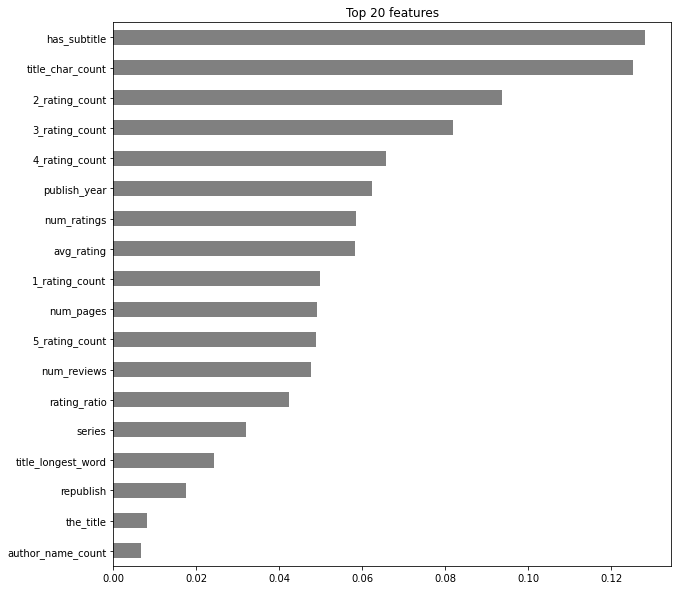

In [34]:
# === Get feature importances === #
rf4 = rf4_search.best_estimator_["rfc"]
importances = pd.Series(rf4.feature_importances_, X_train.columns)

# Plot feature importances
n = 20
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh(color='grey');

The following SHAP plots formalize my observations and provide more insight by showing the effect that the value of each feature had on the model's prediction. The following group are all false negative predictions, meaning the model predicted nonfiction when it was actually fiction.

I also wanted to see what features caused false negatives when the book had neither a high character count nor a subtitle. The third plot below shows the top three as 'republish', 'avg_rating', and 'publish_year'. I was surprised to see 'republish', as it does not seem to be all that important to the model overall. The other two seem to be relatively good predictors, particularly 'avg_rating'.

> [SHAP Plots: False Negatives]

#### False positives

The other side of the confusion matrix again corroborates my initial observation. Many of the same features that provided some additional predictive power also mean some additional mistakes. However, the overall effect was net positive. If it wasn't these features causing the incorrect predictions, it would be others, and there would be more incorrect predictions overall.

> [SHAP Plots: False Positives]

## Deployment

So there you have it, the process of training a machine learning model, from start to finish. The only thing left to do is to deploy it.

I thought it would be interesting to be able to set up a dashboard that can be used to give dynamic inputs to the model and see the resulting prediction. I decided to build the dashboard using Plotly Dash and deploy it to Heroku.

So you don't have to scroll all the way up, here's another link to the live app: print(fiction).

Shoutout to HTML5UP for the template on which I based the design of the app. I made some minor modifications to it, but most of the design was straight from one of his templates.

If you made it this far, I salute you and thank you for reading!